In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from Bayesian2 import BayesianLinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
# Update YearSeason to 'YYYY-S' format
milk_data['YearSeason'] = milk_data['Date'].dt.year.astype(str) + '-' + milk_data['Date'].dt.month.sub(1).floordiv(3).add(1).astype(str)

# Calculate the LactationStartDate
milk_data['LactationStartDate'] = milk_data.groupby(['SE_Number', 'LactationNumber'])['Date'].transform('min')

# Get the Age at the LactationStartDate
lactation_start_age = milk_data[milk_data['Date'] == milk_data['LactationStartDate']].set_index(['SE_Number', 'LactationNumber'])['Age']

# Merge the start age back into the original DataFrame
milk_data = milk_data.merge(lactation_start_age.rename('AgeAtLactationStart'), on=['SE_Number', 'LactationNumber'])

# Encode categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_breeds = pd.DataFrame(encoder.fit_transform(milk_data[['BreedName']]), columns=encoder.get_feature_names_out(['BreedName']))
milk_data = pd.concat([milk_data, encoded_breeds], axis=1)
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,LactationStartDate,AgeAtLactationStart,BreedName_02 SLB,BreedName_04 SJB,BreedName_06 RB,BreedName_27 Montbéliard,BreedName_41 Fjällko,BreedName_99 Korsning/Obest Ras,BreedName_99 Korsning/obestämbar ras,BreedName_Unknown Breed
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8.0,3.0,2022-2,15.22,NaN,...,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8.0,4.0,2022-2,18.96,15.22,...,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8.0,5.0,2022-2,22.64,18.96,...,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8.0,6.0,2022-2,26.49,22.64,...,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8.0,7.0,2022-2,33.61,26.49,...,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576066,2024-08-09,f454e660,SE-f454e660-810,1020,99 Korsning/obestämbar ras,1.0,365.0,2024-3,37.53,31.36,...,2023-05-29,582,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
576067,2024-08-10,f454e660,SE-f454e660-810,1021,99 Korsning/obestämbar ras,1.0,365.0,2024-3,36.48,37.53,...,2023-05-29,582,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
576068,2024-08-11,f454e660,SE-f454e660-810,1022,99 Korsning/obestämbar ras,1.0,365.0,2024-3,34.76,36.48,...,2023-05-29,582,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
576069,2024-08-12,f454e660,SE-f454e660-810,1023,99 Korsning/obestämbar ras,1.0,365.0,2024-3,38.06,34.76,...,2023-05-29,582,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Farm a624fb9a

In [3]:
# Select the farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-30dc5787-1396,2022-1,2479,02 SLB,0.973600,0.989696,-0.027147
1,SE-30dc5787-1402,2022-1,2462,02 SLB,0.981073,0.795121,-0.019674
2,SE-a624fb9a-1039,2022-1,4126,02 SLB,0.991163,1.078977,-0.009584
3,SE-a624fb9a-1198,2022-1,2309,01 SRB,0.934778,1.023293,-0.065968
4,SE-a624fb9a-1199,2022-1,2309,02 SLB,0.928248,1.043481,-0.072499
...,...,...,...,...,...,...,...
650,SE-a624fb9a-1503,2024-3,735,01 SRB,1.027315,1.076425,0.026569
651,SE-a624fb9a-1508,2024-3,783,01 SRB,0.912553,1.179555,-0.088194
652,SE-a624fb9a-1510,2024-3,727,02 SLB,0.974981,1.032800,-0.025766
653,SE-a624fb9a-1511,2024-3,710,01 SRB,1.136428,1.222104,0.135682


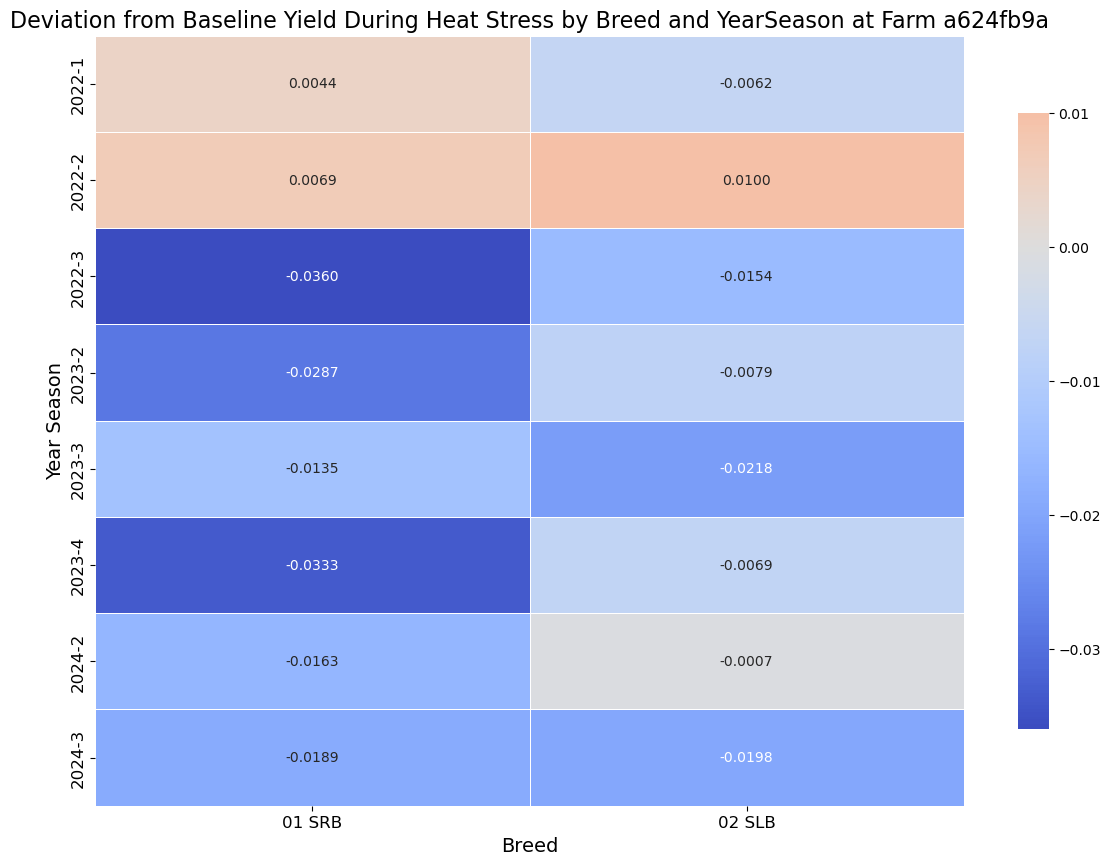

In [4]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

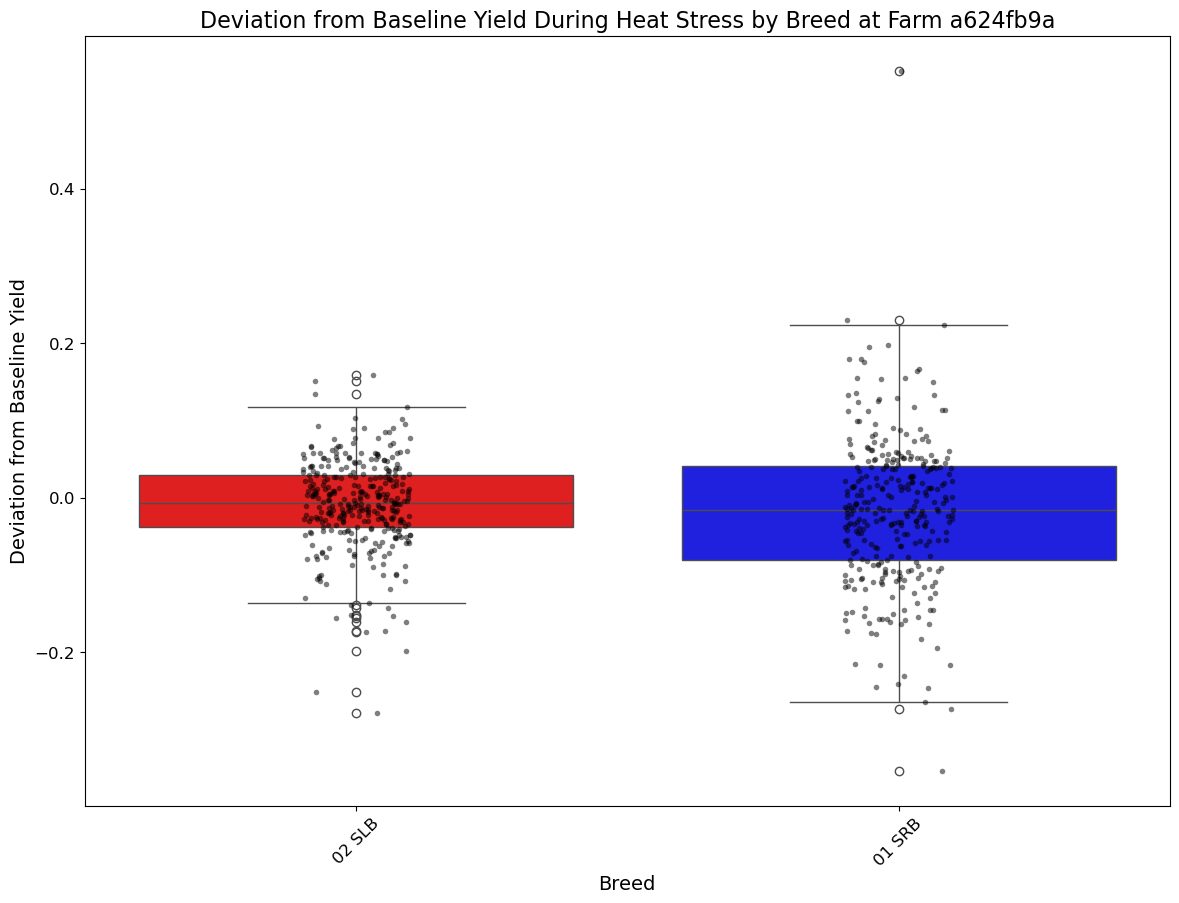

In [5]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF']  # Bright red, Bright blue

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

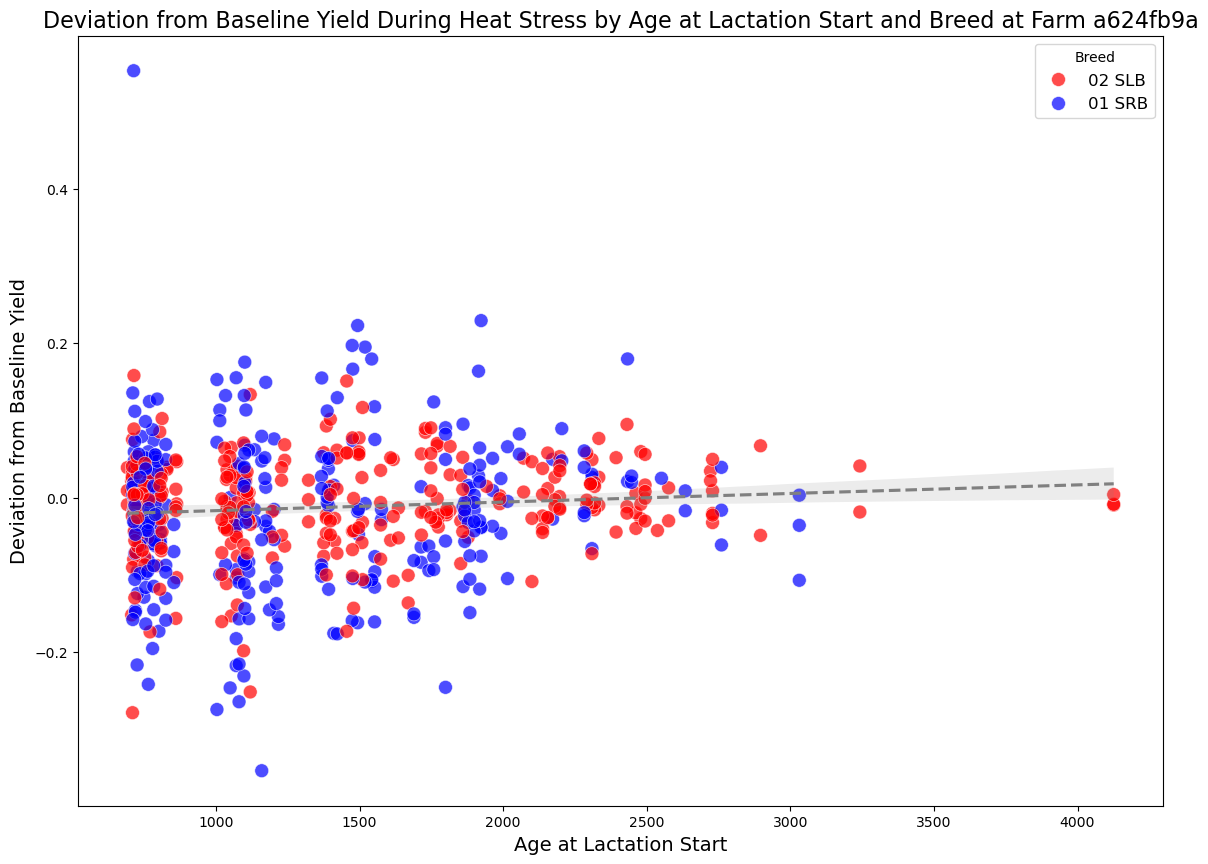

In [6]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

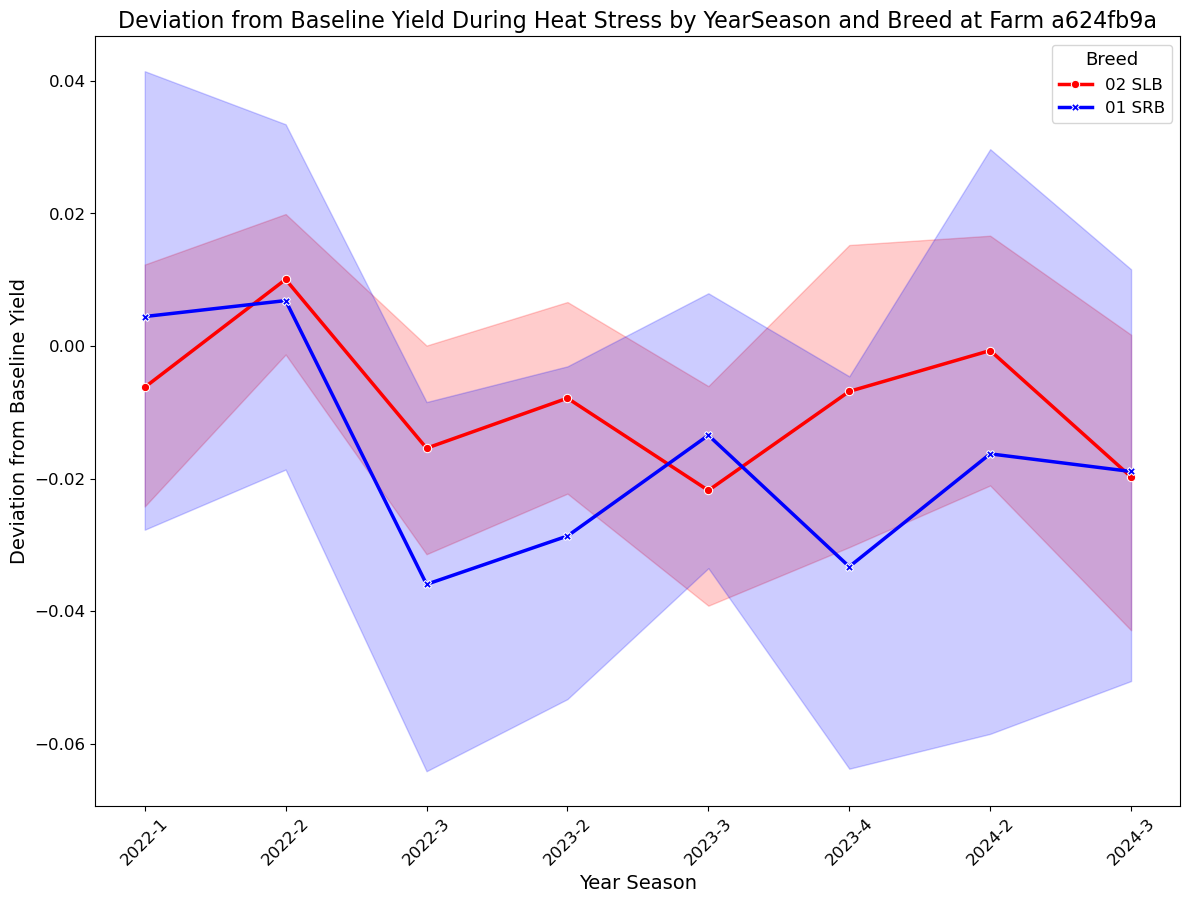

In [7]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm 5c06d92d

In [8]:
# Select the farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-5c06d92d-2055,2022-2,3285,02 SLB,0.986223,1.006910,-0.015084
1,SE-5c06d92d-2058,2022-2,3280,06 RB,0.957435,1.008826,-0.043872
2,SE-5c06d92d-2211,2022-2,2950,02 SLB,0.986866,1.010907,-0.014441
3,SE-5c06d92d-2254,2022-2,2789,02 SLB,0.970571,1.005431,-0.030736
4,SE-5c06d92d-2268,2022-2,2919,02 SLB,0.999436,1.012099,-0.001871
...,...,...,...,...,...,...,...
1604,SE-5c06d92d-3580,2024-3,693,01 SRB,1.108215,1.143821,0.106909
1605,SE-5c06d92d-3583,2024-3,698,02 SLB,0.914609,1.079574,-0.086698
1606,SE-5c06d92d-3584,2024-3,685,02 SLB,1.009785,1.087766,0.008478
1607,SE-5c06d92d-3588,2024-3,686,01 SRB,0.873832,1.056497,-0.127475


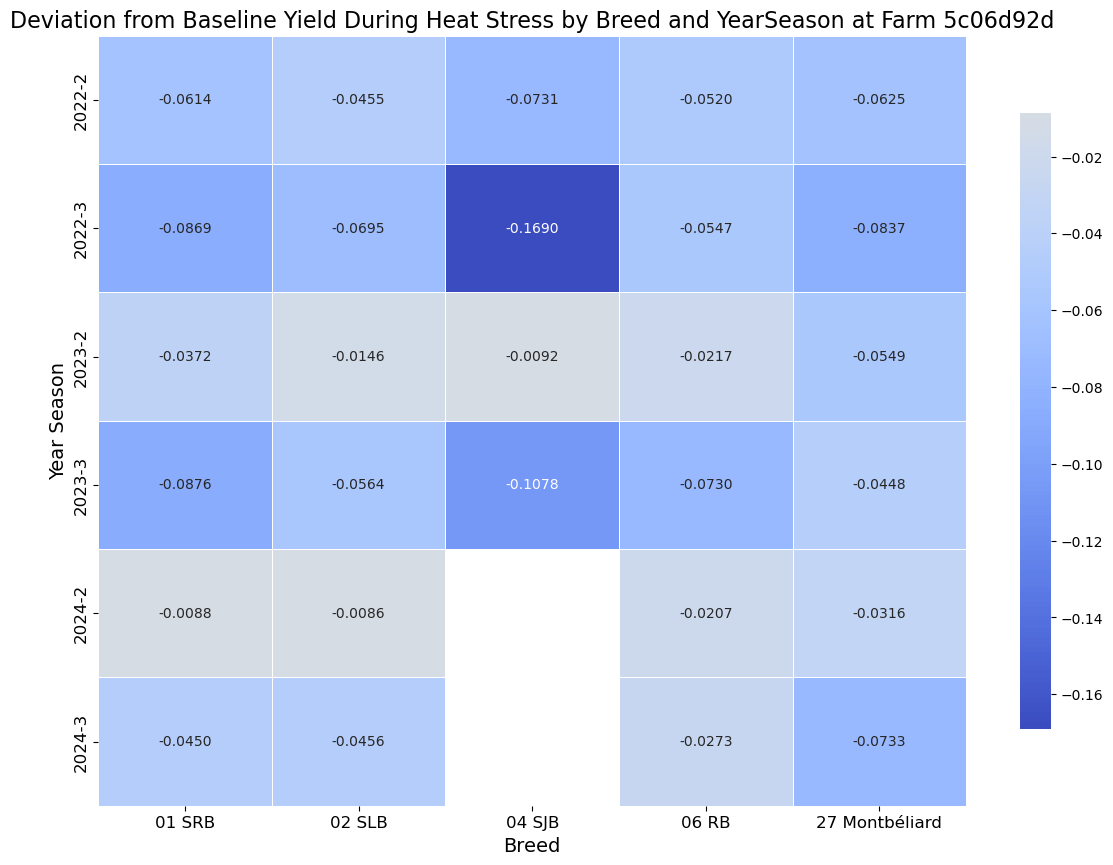

In [9]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

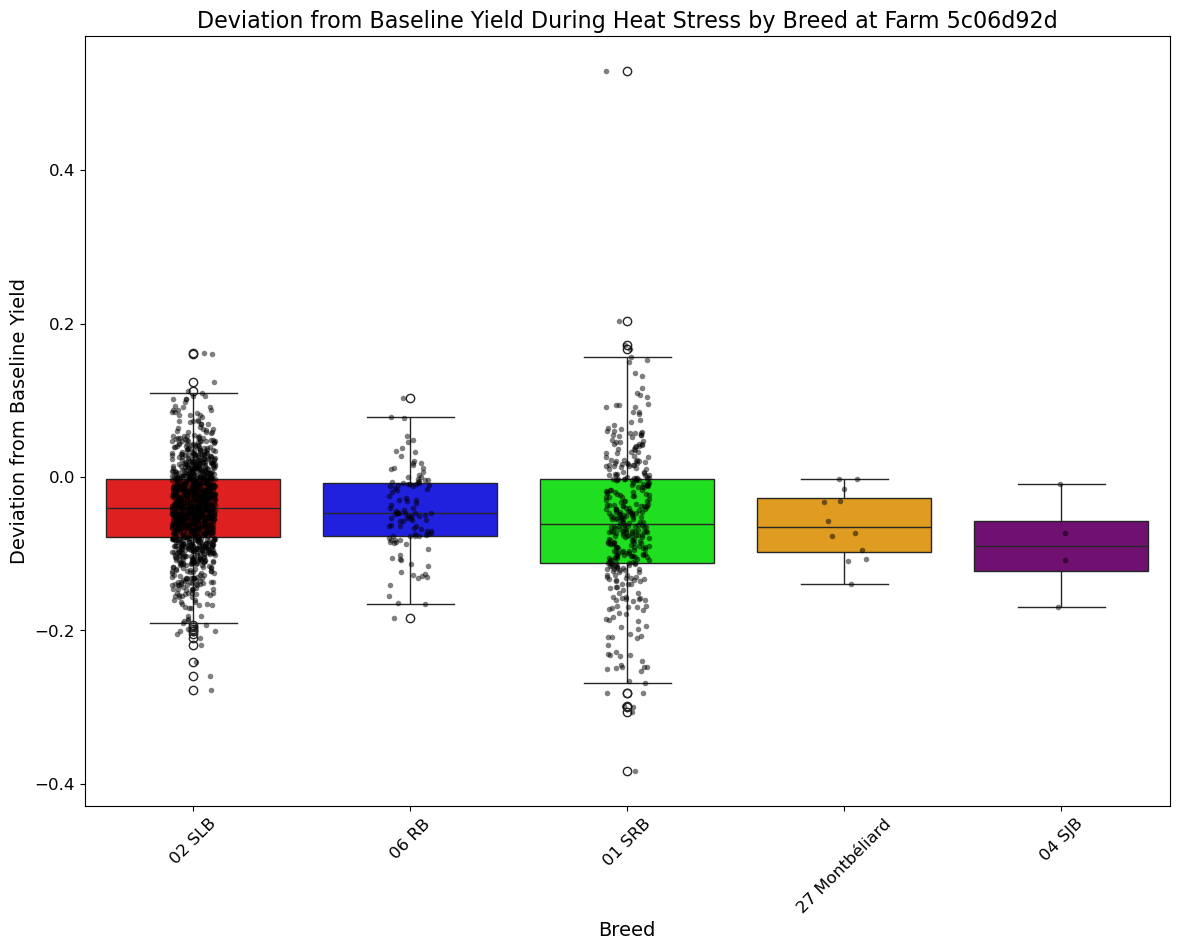

In [10]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080']  # Bright red, Bright blue, Bright green, Bright orange, Bright purple

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

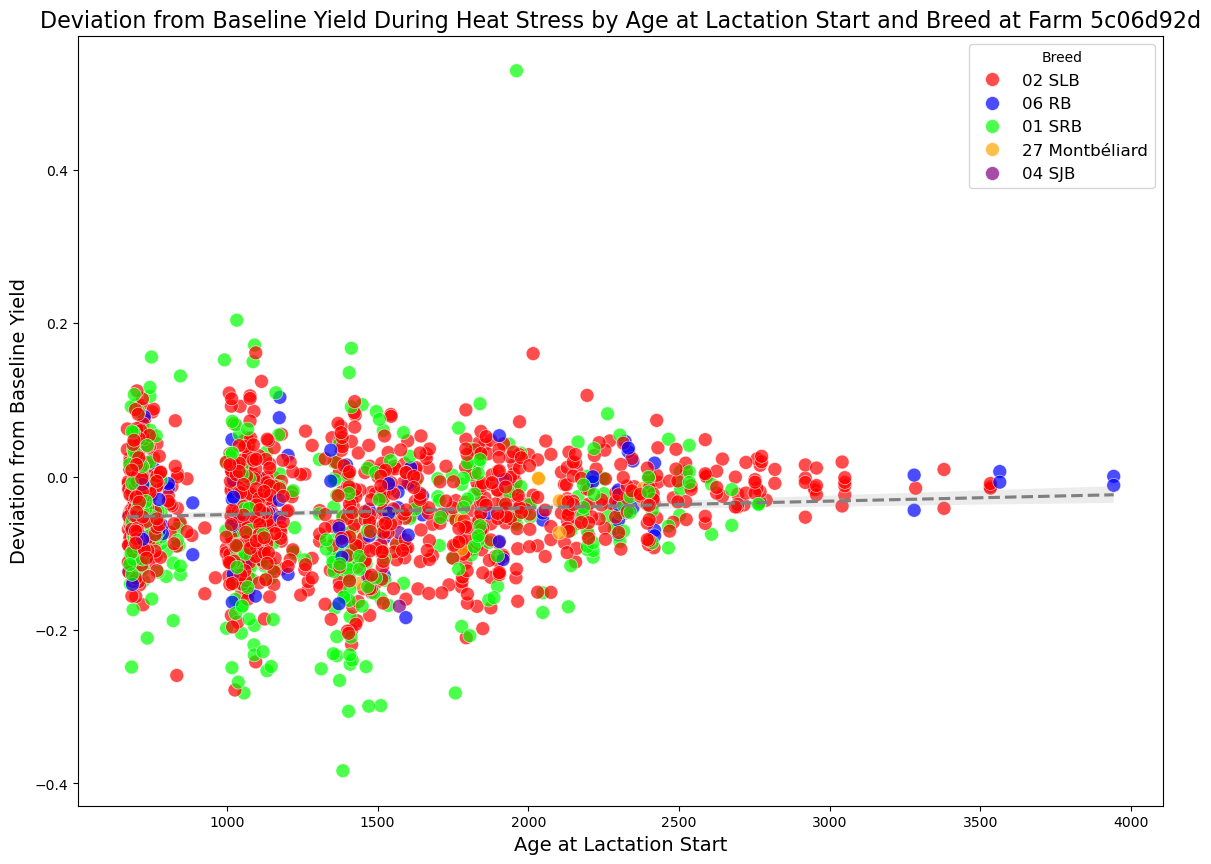

In [11]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

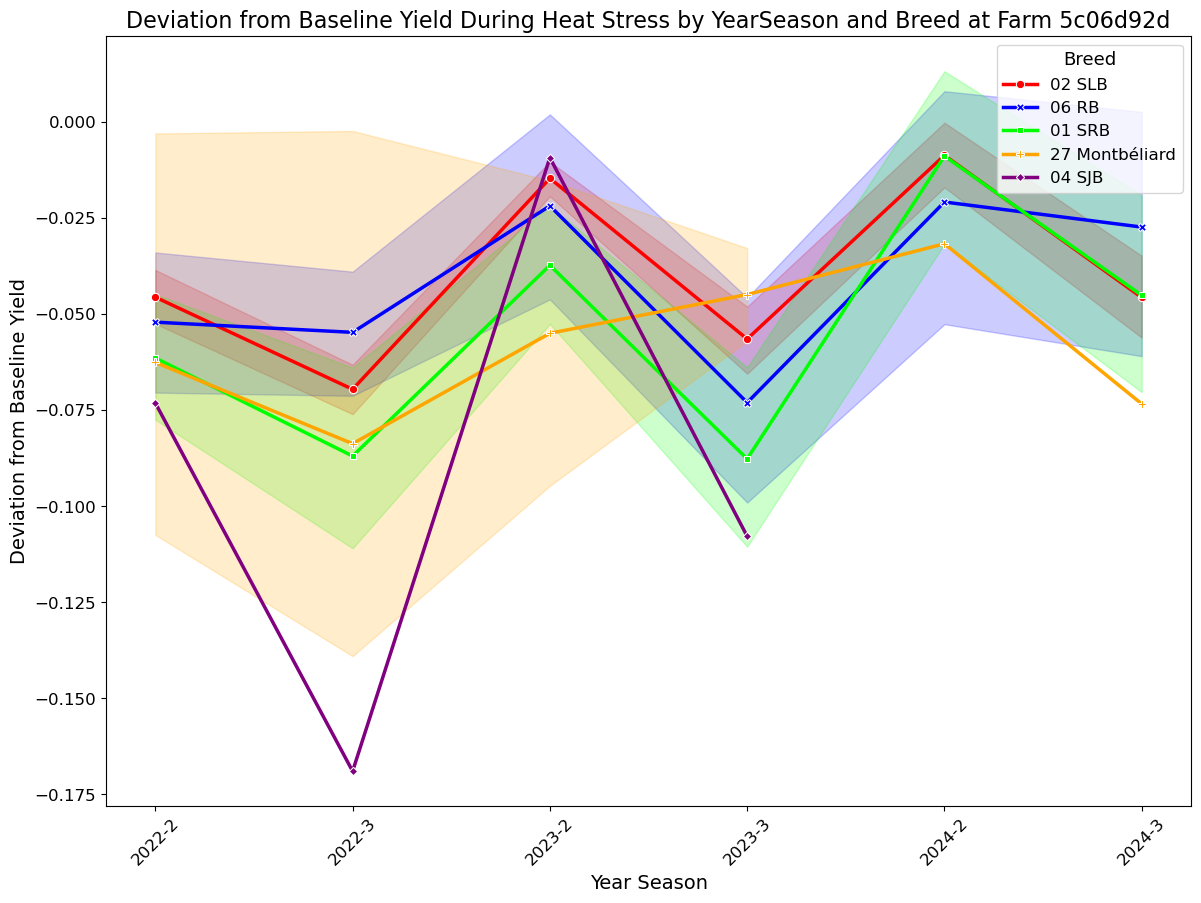

In [12]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm 752efd72

In [13]:
# Select the farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-752efd72-0001,2022-2,2022,Unknown Breed,1.041184,0.993024,0.039596
1,SE-752efd72-0002,2022-2,1966,02 SLB,1.048694,0.947021,0.047106
2,SE-752efd72-0008,2022-2,1896,02 SLB,1.031376,0.935185,0.029788
3,SE-752efd72-0010,2022-2,1953,02 SLB,1.054253,1.028089,0.052665
4,SE-752efd72-0011,2022-2,1966,02 SLB,1.016963,1.007752,0.015375
...,...,...,...,...,...,...,...
1284,SE-752efd72-0566,2024-3,856,02 SLB,1.041170,0.924090,0.039582
1285,SE-752efd72-0567,2024-3,869,02 SLB,0.950807,0.913481,-0.050781
1286,SE-752efd72-0570,2024-3,873,02 SLB,0.898214,1.002486,-0.103374
1287,SE-752efd72-0579,2024-3,865,02 SLB,0.927150,1.097863,-0.074438


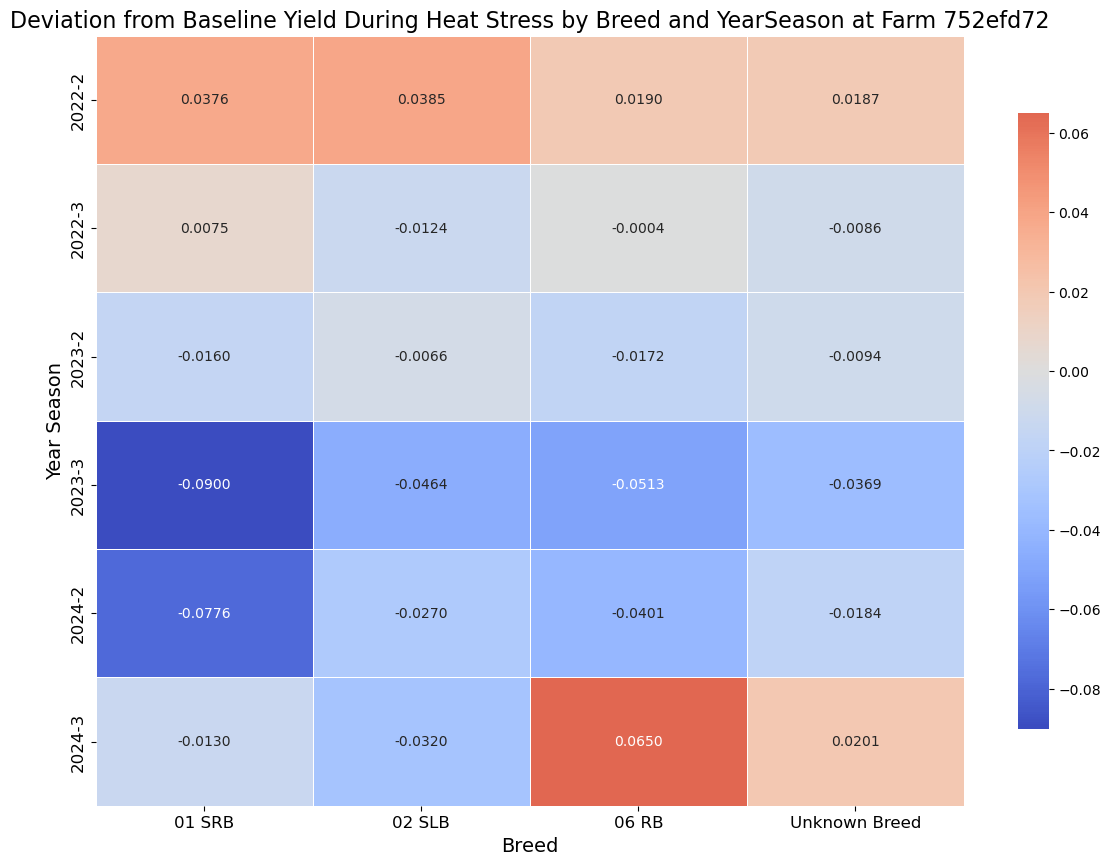

In [14]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

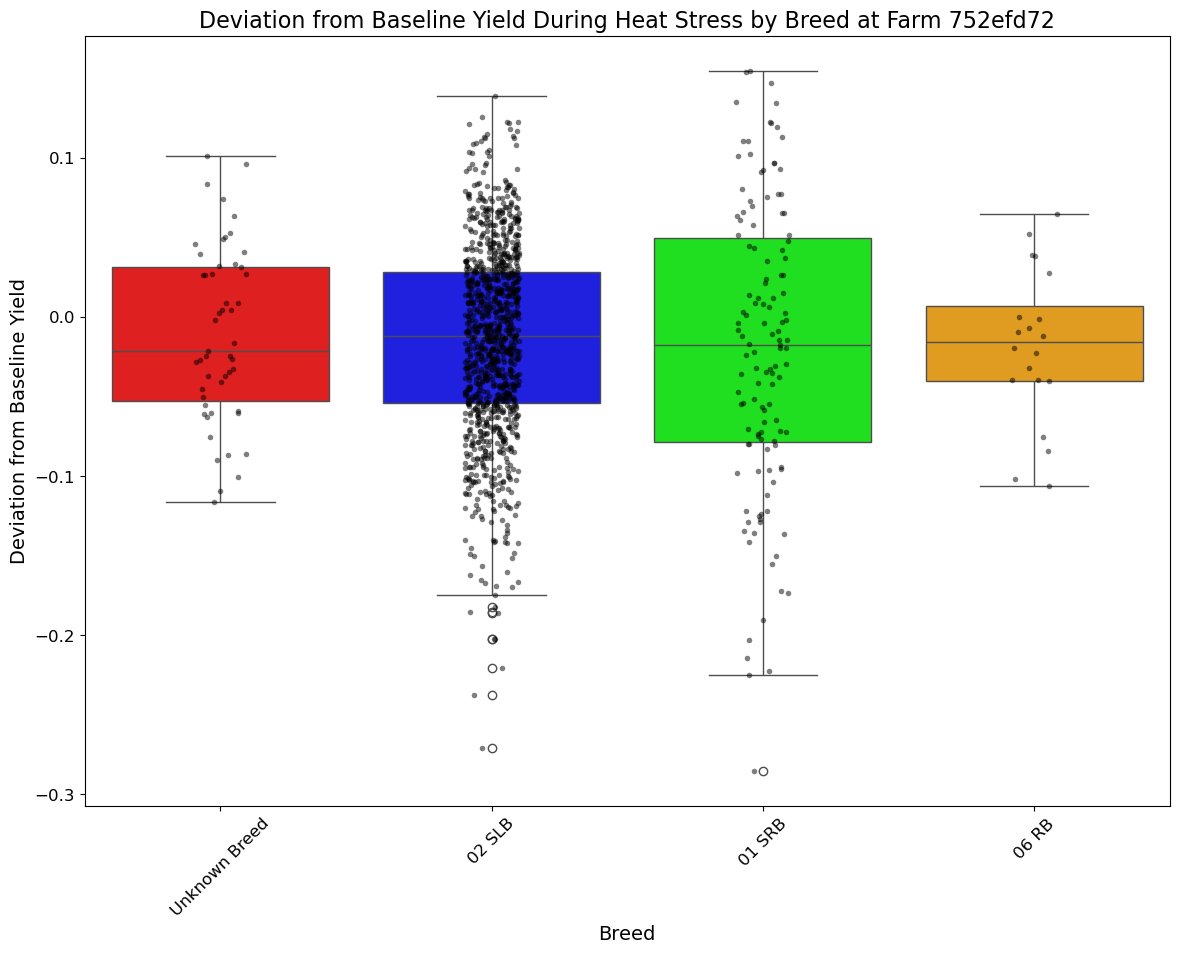

In [15]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500']  # Bright red, Bright blue, Bright green, Bright orange

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

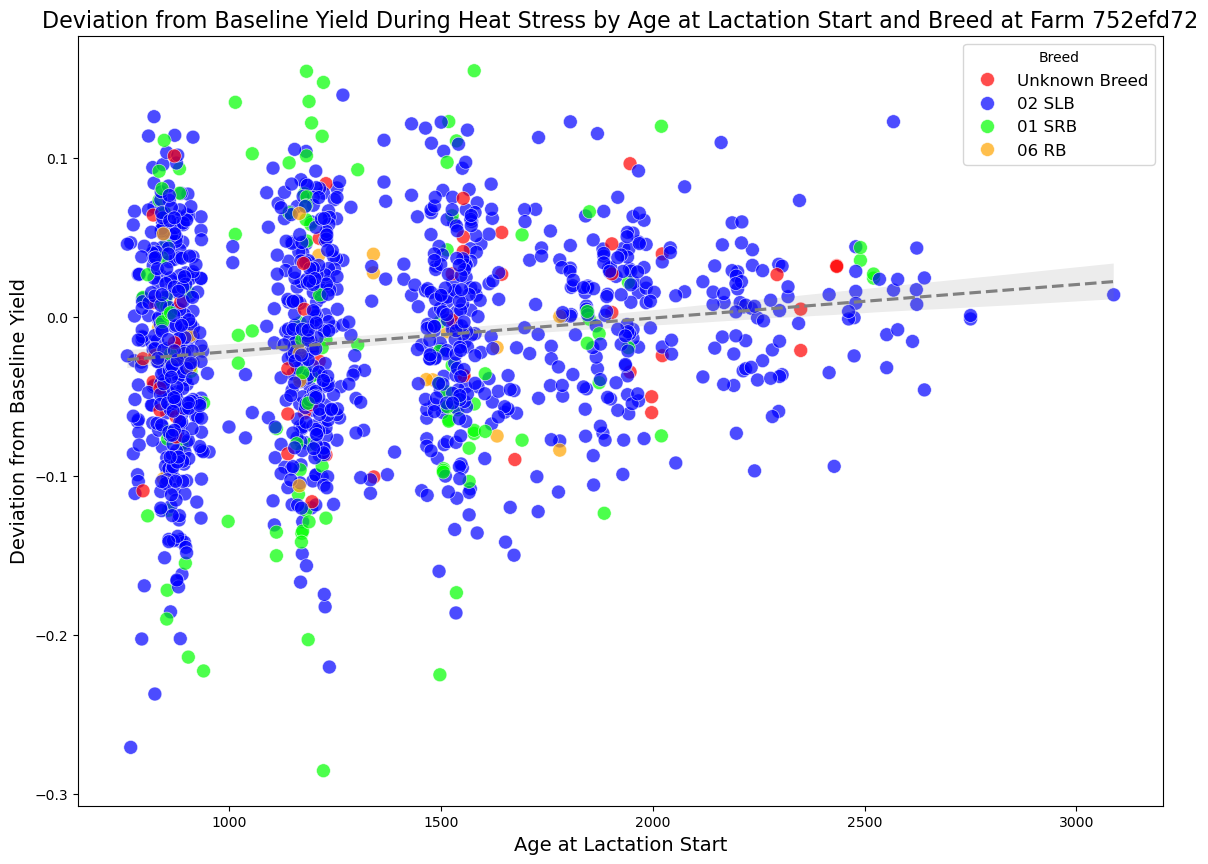

In [16]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

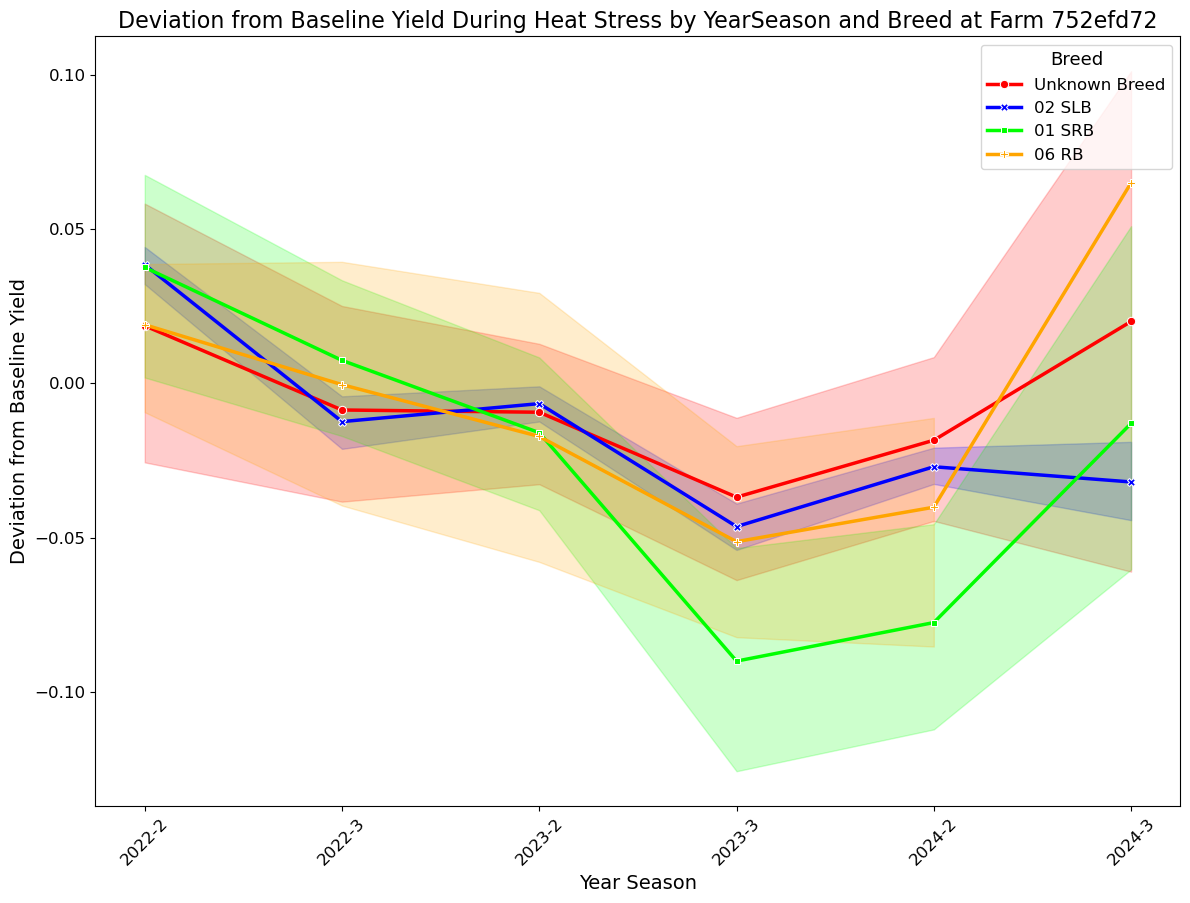

In [17]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm f454e660

In [18]:
# Select the farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-a2bab923-5680-5,2022-2,4202,04 SJB,0.984114,0.973916,-0.016958
1,SE-f454e660-1625,2022-2,2394,04 SJB,0.916284,1.021756,-0.084788
2,SE-f454e660-231,2022-2,2402,02 SLB,0.942087,1.006600,-0.058986
3,SE-f454e660-263,2022-2,2358,02 SLB,0.968165,0.976645,-0.032907
4,SE-f454e660-268,2022-2,2443,01 SRB,0.992479,1.015083,-0.008593
...,...,...,...,...,...,...,...
787,SE-f454e660-789,2024-3,759,02 SLB,1.049998,1.040683,0.048926
788,SE-f454e660-796,2024-3,618,02 SLB,1.089789,1.038230,0.088717
789,SE-f454e660-799,2024-3,651,02 SLB,1.164338,1.072040,0.163266
790,SE-f454e660-804,2024-3,662,02 SLB,0.983131,1.080892,-0.017941


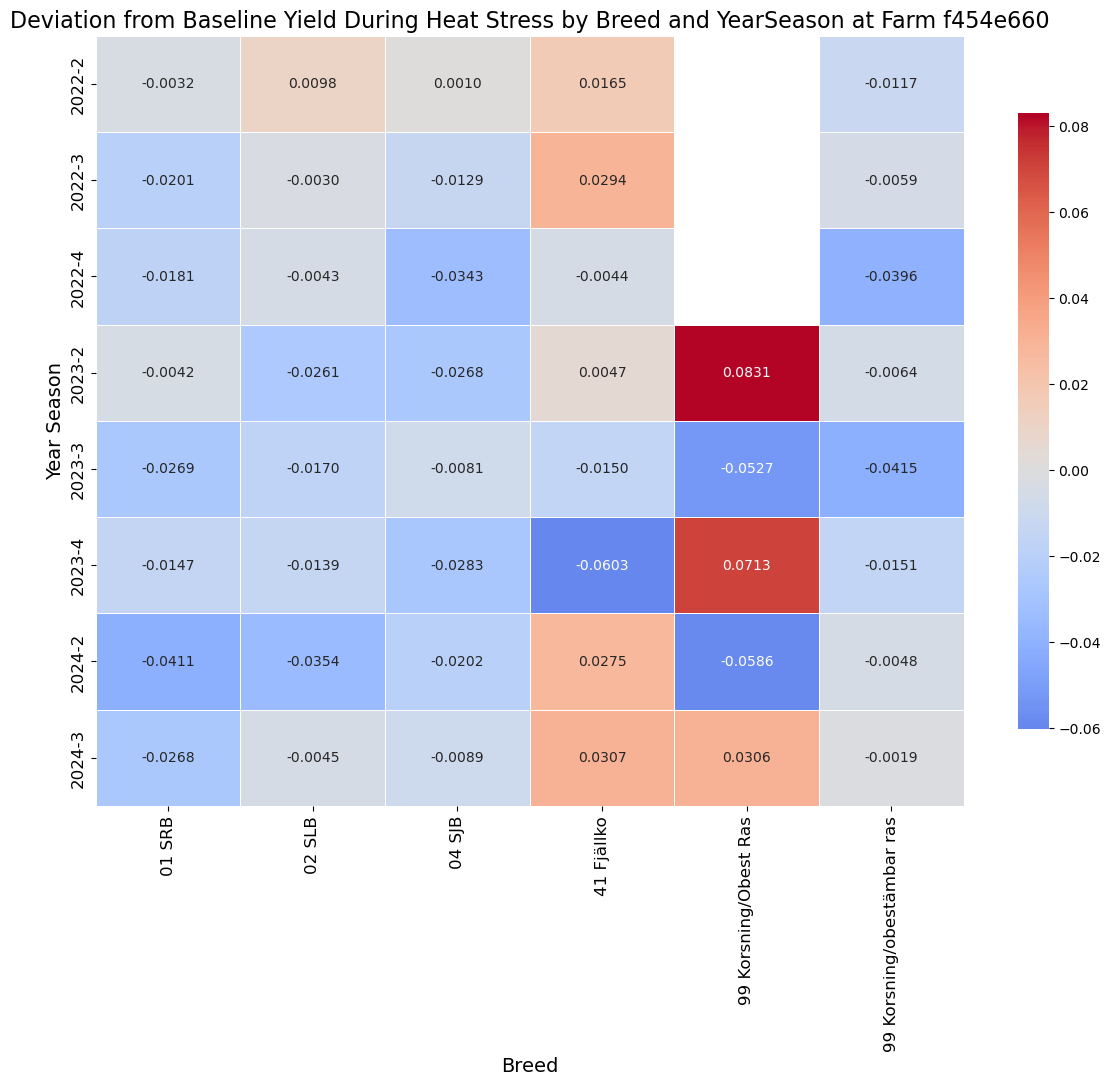

In [19]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

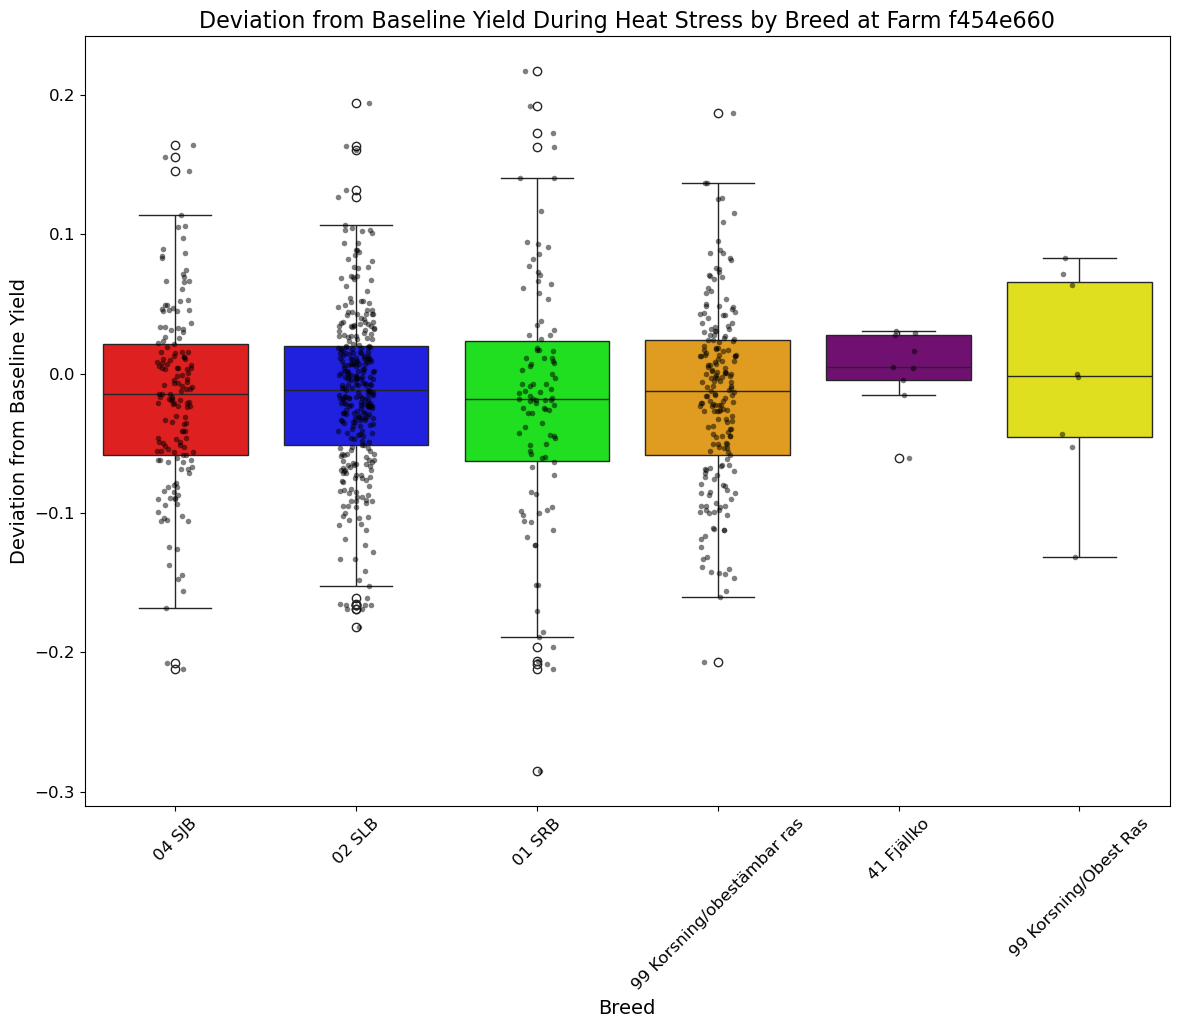

In [20]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080', '#FFFF00']  # Bright red, Bright blue, Bright green, Bright orange, Bright purple, Bright yellow

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

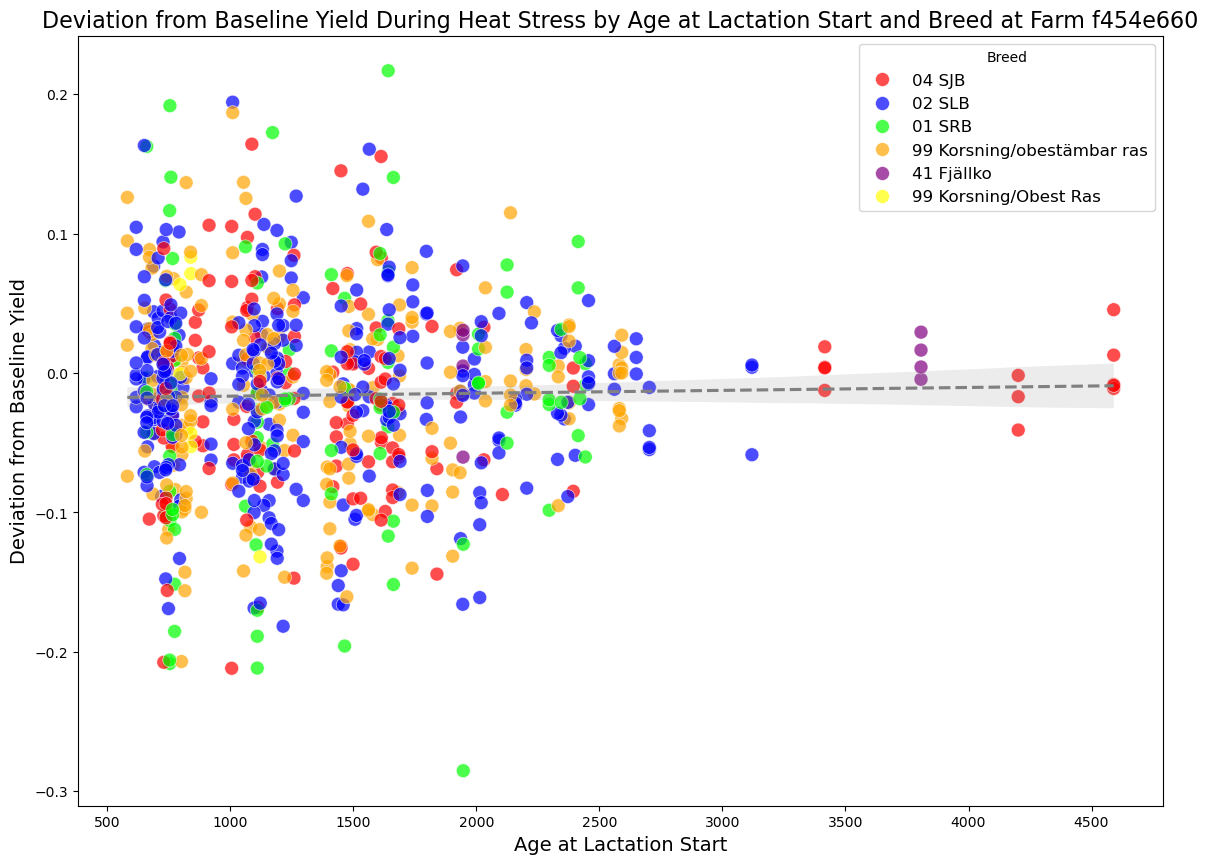

In [21]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

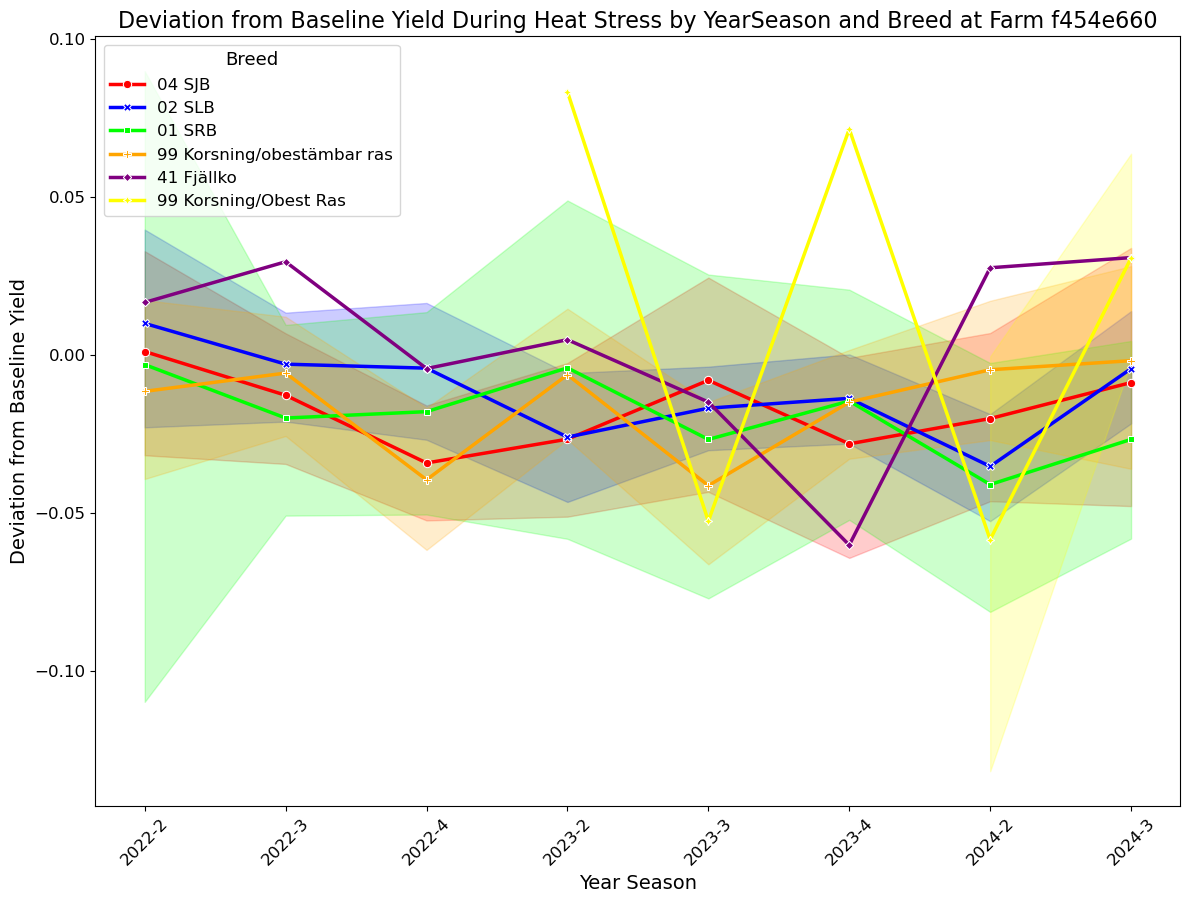

In [22]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()